In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
from PIL import Image
import cv2
import math
from google.colab.patches import cv2_imshow
import torchvision.transforms as transforms

In [50]:
class LightFilter(object):
    def __init__(self, size, data_path, image_path, brightness_limit1, brightness_limit2, mask_size1, mask_size2, shift_x, shift_y, angle):
        
        """    
        size: (width, height) - the number of pixels of image
        data_path : path to dataset with data distribution
        image_path: path to the image
        brightness_limit1: first limit for range for changing brightness
        brightness_limit2: second limit for range for changing brightness
        mask_size1: specified width of mask
        mask_size2: specified height of mask
        shift_x: shift of mask on x-axis from the center of image
        shift_y: shift of mask on y-axis from the center of image
        angle: the angle of rotation of mask (in range(0, 360))   """

        self.size = size
        self.data_path = data_path
        self.image_path = image_path
        self.brightness_limit1 = brightness_limit1
        self.brightness_limit2 = brightness_limit2
        self.mask_size1 = mask_size1
        self.mask_size2 = mask_size2
        self.shift_x = shift_x
        self.shift_y = shift_y
        self.angle = angle


    def compression_stretching(self, mask):

        """ Input: 

                  mask, (np.array) - input mask 

            Output: 

                  img, (np.array) - compressed or stretched image  """

        # define differences in image and mask widths and heights in pixels          
        pad1 = (self.size[0]- self.mask_size1)
        pad2 = (self.size[1]- self.mask_size2)

        # apply padding (filling the matrix with zeros to the specified dimensions)
        # adding zeros by width and height to the mask, which is located in the center of the image by default
        # apply math.ceil() for rounding non-integers up
        # zero is a constant (padding_mode = 'constant' , fill = 0)
        transform = transforms.Pad((math.ceil((self.size[0]- self.mask_size1 )/2 ) , math.ceil((self.size[1]- self.mask_size2 )/2 ) ), fill = 0, padding_mode = 'constant')

        # checking the padding width(heiht) on parity 
        # if width(heiht) is odd, redefining the width(height), reduce by 1, because before it used math.ceil()
        if (abs(pad1/2 - math.ceil(pad1/2)) == 0.5):
          mask_size1_ = self.mask_size1 - 1
        else:
          mask_size1_ = self.mask_size1
        if (abs(pad2/2 - math.ceil(pad2/2)) == 0.5):
          mask_size2_ = self.mask_size2 - 1
        else:
          mask_size2_ = self.mask_size2

        # resize mask to defined sizes without interpolation and withot scalinf on horizontal and vertical axes
        resized_mask = cv2.resize(mask, (mask_size1_, mask_size2_), fx = 1, fy = 1, interpolation = None)

        # convert resized_mask to PIL.Image format for applying transform
        pil_mask = Image.fromarray(resized_mask)

        # apply padding to pil_mask
        pil_mask = transform(pil_mask)

        # convert pil_mask to np.array from PIL.Image format
        new_mask = np.array(pil_mask)

        # restore the mask format reshaping it with one color channe
        new_mask = new_mask[:,:,np.newaxis]

        return(new_mask)

    def changing_mask_center(self, mask):

        """" Input: 

                  mask, (np.array) - input mask
                  
            Output: 
                  
                  res, (np.array) - shifted mask  """

        # define M - matrix of shift with the specified parameters of the shift along the x and y axes relative to the center of the mask
        M = np.float32([[1, 0, self.shift_x], [0, 1, self.shift_y]])

        # obtain the dimension of the input image
        (rows, cols) = mask.shape[:2]

        # makes a shift
        res = cv2.warpAffine(mask, M, (cols, rows))

        # restore the image format reshaping it with one color channe
        res = res[:,:,np.newaxis]

        return(res)

    
    def mask_preparation(self):
        """ creates a distribution mask from a file, normalizing the original values """
        """" Input: 
                  
                  -
                  
            Output:
                    
                  mask, (np.array) - mask from the changed dataset """

        # reading the dataset on self.data_path           
        data = pd.read_csv(self.data_path, sep=" ", header=None)

        # define minimal value in initial dataset 
        minimal_el = data.min(axis = 1).min()

        # define maximum value in initial dataset
        max_el = data.max(axis = 1).max()

        # normalize the dataset values from interval [4.9, 6.66] to interval [0, 1]
        data = (data - minimal_el)/(max_el - minimal_el)

        # convert data to np.array from the pd.DataFrame 
        mask = data.to_numpy()

        # BILINEAR mask interpolation to size = self.size
        mask = np.array(Image.fromarray(mask).resize(self.size, Image.BILINEAR))

        # restore the mask format reshaping it with one color channe
        mask = mask[:,:,np.newaxis]
        
        return(mask)

    
    def bright_image(self):
  
        """ Input: 
                    -
            Output: 
                    src_light_, (np.array) - fully illuminated image """

        # open image in PIL.Image format on the self.image_path
        img = Image.open(self.image_path)

        # resize opened image to self.size
        out = img.resize(self.size)

        # convert the image from PIL.Image format to np.array format
        img_np = np.array(out)

        # convert image to RGB color space from BGR color space
        # because open cv reads the image in BGR color format
        image = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

        # define the augmentation from the Albumenation library
        # this augmentation always applyes (always_apply= True), with probability of applying the transform = 1 (p = 1.0)
        # the brightness_limits passed in the construction, contrast_limit is cinstant and equals to 1
        transform = A.Compose([ A.RandomBrightnessContrast(always_apply= True, p=1.0,
                    brightness_limit=(self.brightness_limit1, self.brightness_limit2), contrast_limit=(1.0, 1.0))])

        # applying the augmentation to image 
        transformed = transform(image=image)

        # define src_light as np.array , because transformed is a dict
        src_light = transformed['image']

        # convert illuminated image to initial color format (BGR)
        src_light_  = cv2.cvtColor(src_light, cv2.COLOR_RGB2BGR)

        return(src_light_)

    def mask_rotation(self, mask):

        """  Input: 

                  mask, (np.array) - input mask  

             Output: 

                  res, (np.array) - the rotated mask   """

        # obtain the dimension of the input image
        (rows, cols) = mask.shape[:2] 

        # define a rotation matrix with the mask's center
        # the rotation angle passed in the construction with no scaling (1)
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), self.angle, 1)

        # makes a rotation
        res = cv2.warpAffine(mask, M, (cols, rows))

        # restore the image format reshaping it with one color channe
        res = res[:,:,np.newaxis]

        return(res)


    def final_image(self,  mask, src_light, src1):

        """ Input:

                  mask, (np.array) - input mask 
                  src_light, (np.array) - a picture with illumination is the result of bright_image function
                  src1, (np.array) - initial picture with resize as self.size

            Output:

                  np_array_img, (np.array) - the final image with the use of a lighted mask """
          
        # leaves a light spot (mask shape) on the image
        dst = src_light * mask + src1 * (1 - mask)

        # change the image encoding to np.uint8
        dst = Image.fromarray(dst.astype(np.uint8))

        # converting an image to np.array from the format PIL.Image
        np_array_img = np.array(dst)

        return(dst)

  
    def initial_picture(self):
        """ brings the original image to the desired size and returns it as np.array """

        """ Input: 
                  -

            Output: 
                  
                  img_np , (np.array) - initial picture with """

        # open image in jpg and png formats, convert then to PIL.Image format
        img = Image.open(self.image_path)

        # resize the PIL.Image to self.size from the __init__ function
        out = img.resize(self.size)

        # convert resized PIL.Image to np.array
        img_np = np.array(out)

        return(img_np)

# Results

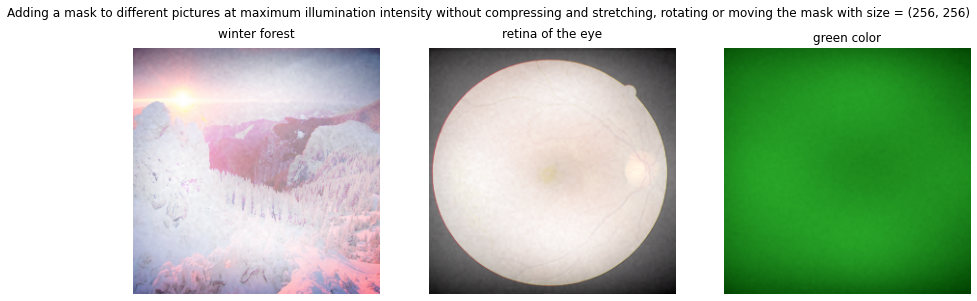

In [51]:
ex1 = LightFilter((256,256), "detector-data-100m.txt", "photo2.jpg", 1, 1 , 256, 256, 0, 0, 0)
ex2 = LightFilter((256,256), "detector-data-100m.txt", "vein.png", 1, 1 , 256, 256, 0, 0, 0)
ex3 = LightFilter((256,256), "detector-data-100m.txt", "green.png", 1, 1 , 256, 256, 0, 0, 0)
pic1 = ex1.final_image(ex1.mask_preparation(), ex1.bright_image(), ex1.initial_picture())
pic2 = ex2.final_image(ex2.mask_preparation(), ex2.bright_image(), ex2.initial_picture())
pic3 = ex3.final_image(ex3.mask_preparation(), ex3.bright_image(), ex3.initial_picture())
pictures = [pic1, pic2, pic3]
pic_box = plt.figure(figsize=(15,15))
names = ['winter forest','retina of the eye','green color']

for i, picture in enumerate(pictures):
    pic_box.add_subplot(1,3,i+1)
    plt.imshow(picture)
    plt.title(label=names[i], pad=10)
    plt.axis('off')
  
plt.title(y = 1.1, loc = 'right', label = "Adding a mask to different pictures at maximum illumination intensity without compressing and stretching, rotating or moving the mask with size = (256, 256)")
plt.show() 


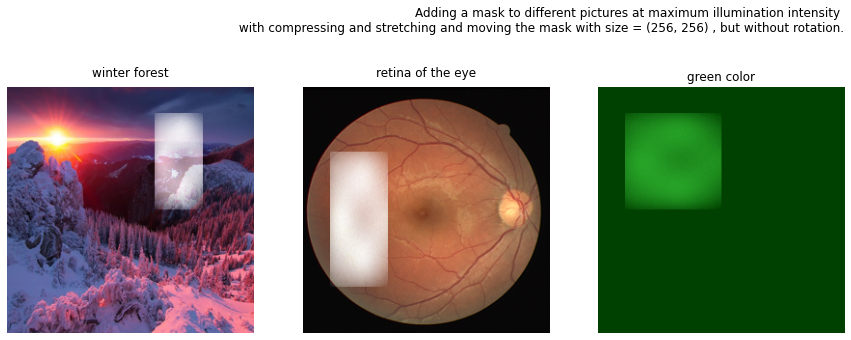

In [52]:
ex1 = LightFilter((256,256), "detector-data-100m.txt", "photo2.jpg", 1, 1 , 50, 100, 50, -50, 0)
ex2 = LightFilter((256,256), "detector-data-100m.txt", "vein.png", 1, 1 , 60, 140, -70, 10, 0)
ex3 = LightFilter((256,256), "detector-data-100m.txt", "green.png", 1, 1 , 100, 100, -50, -50, 0)
pic1 = ex1.final_image(ex1.changing_mask_center(ex1.compression_stretching(ex1.mask_preparation())), 
                       ex1.bright_image(), ex1.initial_picture())
pic2 = ex2.final_image(ex2.changing_mask_center(ex2.compression_stretching(ex2.mask_preparation())), 
                       ex2.bright_image(), ex2.initial_picture())
pic3 = ex3.final_image(ex3.changing_mask_center(ex3.compression_stretching(ex3.mask_preparation())), 
                       ex3.bright_image(), ex3.initial_picture())
pictures = [pic1, pic2, pic3]
pic_box = plt.figure(figsize=(15,15))
names = ['winter forest','retina of the eye','green color']

for i, picture in enumerate(pictures):
    pic_box.add_subplot(1,3,i+1)
    plt.imshow(picture)
    plt.title(label=names[i], pad=10)
    plt.axis('off')
  
plt.title(y = 1.2, loc = 'right', label = "Adding a mask to different pictures at maximum illumination intensity \n with compressing and stretching and moving the mask with size = (256, 256) , but without rotation.")
plt.show() 

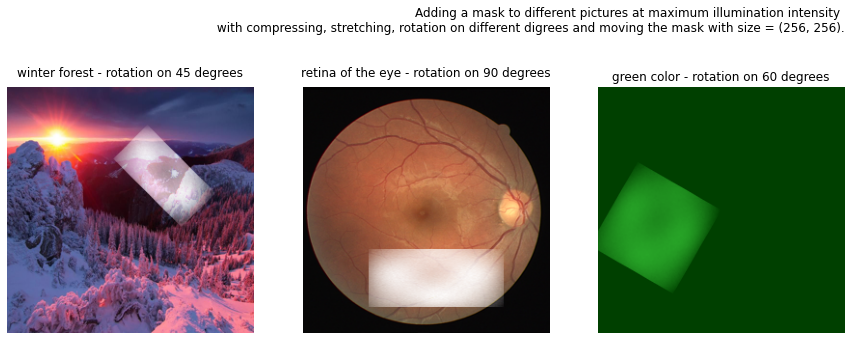

In [53]:
ex1 = LightFilter((256,256), "detector-data-100m.txt", "photo2.jpg", 1, 1 , 50, 100, 50, 0, 45)
ex2 = LightFilter((256,256), "detector-data-100m.txt", "vein.png", 1, 1 , 60, 140, -70, 10, 90)
ex3 = LightFilter((256,256), "detector-data-100m.txt", "green.png", 1, 1 , 100, 100, -50, -50, 60)
pic1 = ex1.final_image(ex1.mask_rotation(ex1.changing_mask_center(ex1.compression_stretching(ex1.mask_preparation()))),
                       ex1.bright_image(), ex1.initial_picture())
pic2 = ex2.final_image(ex2.mask_rotation(ex2.changing_mask_center(ex2.compression_stretching(ex2.mask_preparation()))), 
                       ex2.bright_image(), ex2.initial_picture())
pic3 = ex3.final_image(ex3.mask_rotation(ex3.changing_mask_center(ex3.compression_stretching(ex3.mask_preparation()))), 
                       ex3.bright_image(), ex3.initial_picture())
pictures = [pic1, pic2, pic3]
pic_box = plt.figure(figsize=(15,15))
names = ['winter forest - rotation on 45 degrees','retina of the eye - rotation on 90 degrees',
         'green color - rotation on 60 degrees']

for i, picture in enumerate(pictures):
    pic_box.add_subplot(1,3,i+1)
    plt.imshow(picture)
    plt.title(label=names[i], pad=10)
    plt.axis('off')
  
plt.title(y = 1.2, loc = 'right',
label = "Adding a mask to different pictures at maximum illumination intensity \n with compressing, stretching, rotation on different digrees and moving the mask with size = (256, 256).")
plt.show() 